<a href="https://colab.research.google.com/github/Brikca/tlkm-hybrid-time-series-forecasting/blob/main/TLKM_Stock_Price_Forecasting_using_Hybrid_Auto_ARIMA_and_LSTM_with_Swarm_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pmdarima
# !pip install pyswarm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=a263a851b8028e13cc5d79ddc329468de18e6759ba55874afa9c80ffe48ce421
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


In [ ]:
# !pip install numpy==1.26.4 --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 164.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import yfinance as yf
from pmdarima import auto_arima
from pyswarm import pso
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import date, datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_percentage_error as mape
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
data = pd.read_csv('/content/SAHAM - PT Telekomunikasi Indonesia Tbk (TLKM.JK) - Sheet1 (2).csv')
data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,07/11/2019,3216.63,4070.0,4150.0,3990.0,4150.0,125.291.200
1,08/11/2019,3248.24,4110.0,4120.0,3990.0,4010.0,70.404.800
2,11/11/2019,3240.34,4100.0,4120.0,4040.0,4040.0,57.079.800
3,12/11/2019,3303.57,4180.0,4190.0,4050.0,4050.0,88.251.100
4,13/11/2019,3279.86,4150.0,4170.0,4100.0,4130.0,91.925.700


In [ ]:
df_close = data[['Date', 'Close']]
list(df_close)
df_close.head(5)

,Date,Close
0,07/11/2019,4070.0
1,08/11/2019,4110.0
2,11/11/2019,4100.0
3,12/11/2019,4180.0
4,13/11/2019,4150.0


In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
df_close = data[['Date', 'Close']].copy()
df_close.set_index('Date', inplace=True)

# **Preprocessing Data**

In [ ]:
# Cek missing value dan duplikat tanggal
print("Jumlah data hilang:\n", df_close.isnull().sum())
print("Tanggal duplikat:\n", df_close[df_close.index.duplicated(keep=False)])

Jumlah data hilang:
 Close    0
dtype: int64
Tanggal duplikat:
 Empty DataFrame
Columns: [Close]
Index: []


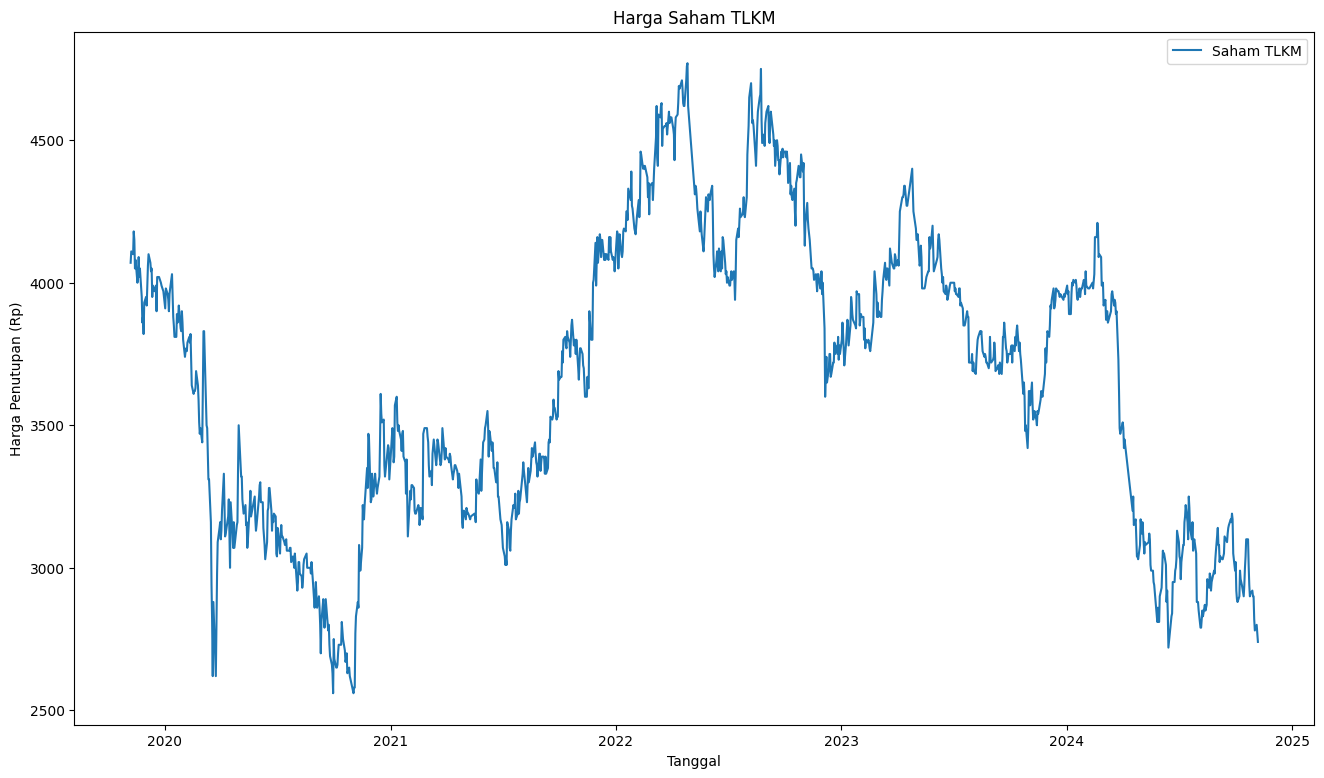

In [ ]:
# Visualisasi Harga Saham
plt.figure(figsize=(16, 9))
plt.plot(df_close, label='Saham TLKM')
plt.title('Harga Saham TLKM')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (Rp)')
plt.legend()
plt.show()

In [ ]:
# plit Data (80% train, 20% test)
split_idx = int(len(df_close) * 0.8)
df_train = df_close.iloc[:split_idx]
df_test = df_close.iloc[split_idx:]

# **Auto-ARIMA**

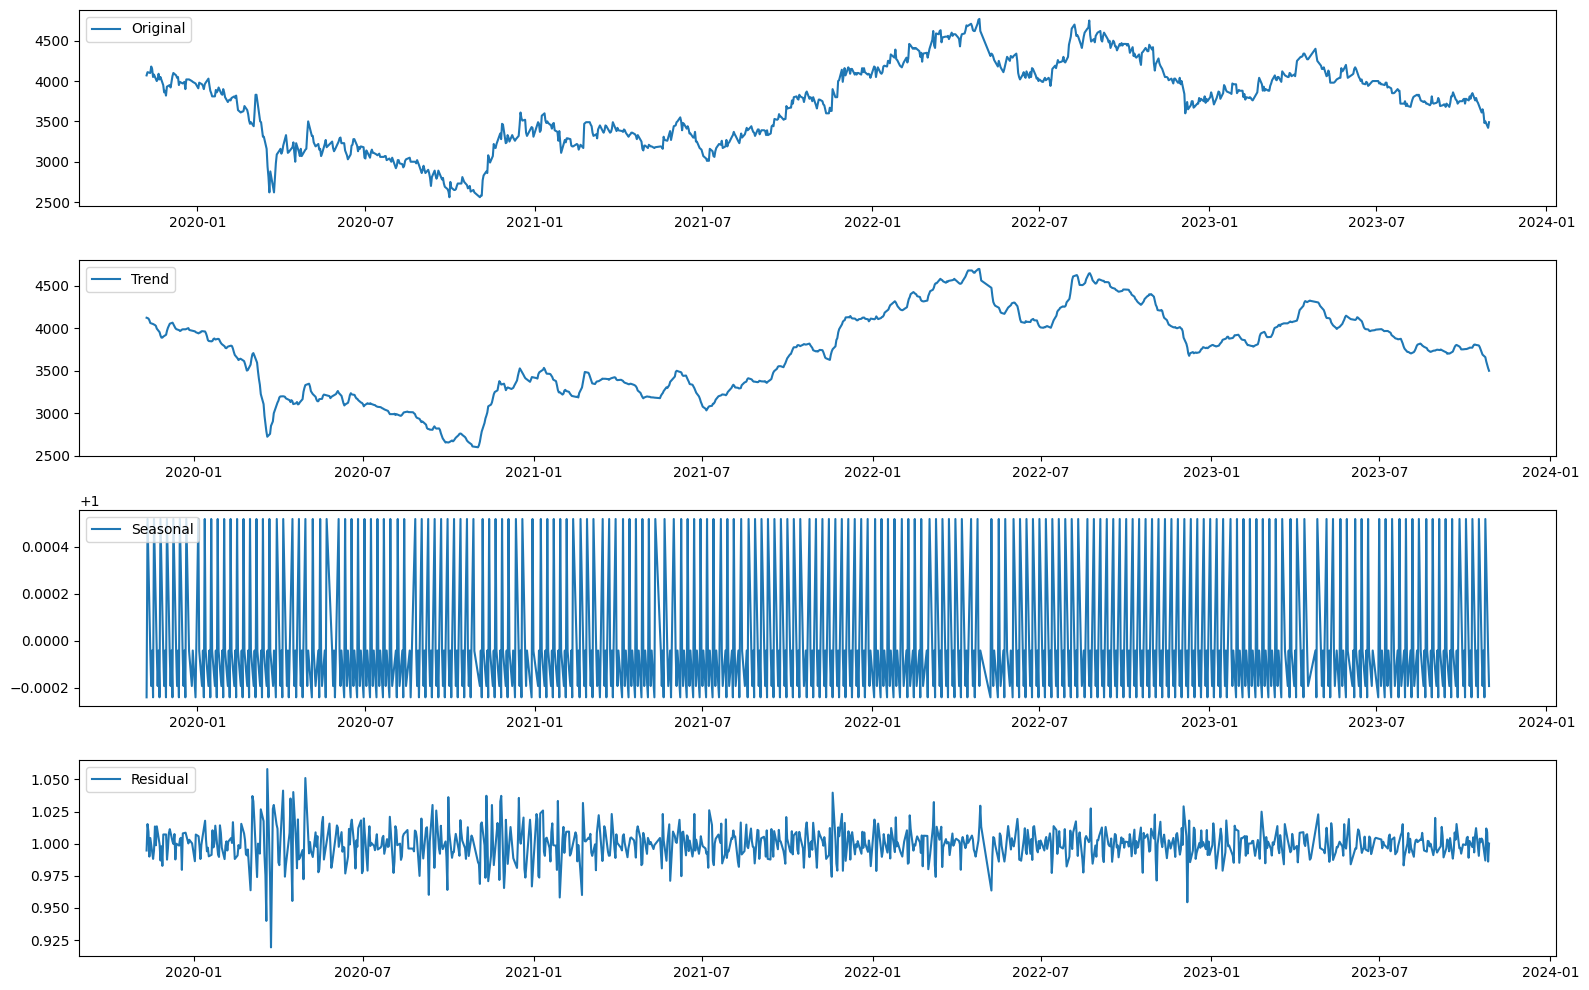

In [ ]:
#Dekomposisi
from statsmodels.tsa.seasonal import seasonal_decompose

dekomposisi = seasonal_decompose(df_train['Close'], model='multiplicative', period=5)
fig, ax = plt.subplots(4, 1, figsize=(16, 10))
ax[0].plot(df_train, label='Original')
ax[1].plot(dekomposisi.trend, label='Trend')
ax[2].plot(dekomposisi.seasonal, label='Seasonal')
ax[3].plot(dekomposisi.resid, label='Residual')
for a in ax: a.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Differencing + Log Transform
data_log = np.log(df_train['Close'])
data_log_diff = data_log.diff().dropna()
data_log_diff

,Close
Date,
2019-11-08,0.009780
2019-11-11,-0.002436
2019-11-12,0.019324
2019-11-13,-0.007203
2019-11-14,-0.024391
...,...
2023-10-25,-0.013793
2023-10-26,-0.033902
2023-10-27,0.005731


In [ ]:
# Compute mean of log transformed and differenced data
log_mean = data_log.mean()
diff_mean = data_log_diff.mean()

log_mean, diff_mean

(8.21176032964832, -0.00015882361904976172)

In [ ]:
# Uji ADF setelah differencing
print("\nADF Test Setelah Log + Differencing:")
result_adf2 = adfuller(data_log_diff)
print(pd.Series(result_adf2[:4], index=['Test Statistic', 'p-value', 'Lags Used', 'N Obs Used']))


ADF Test Setelah Log + Differencing:
Test Statistic   -8.769842e+00
p-value           2.538526e-14
Lags Used         1.400000e+01
N Obs Used        9.530000e+02
dtype: float64


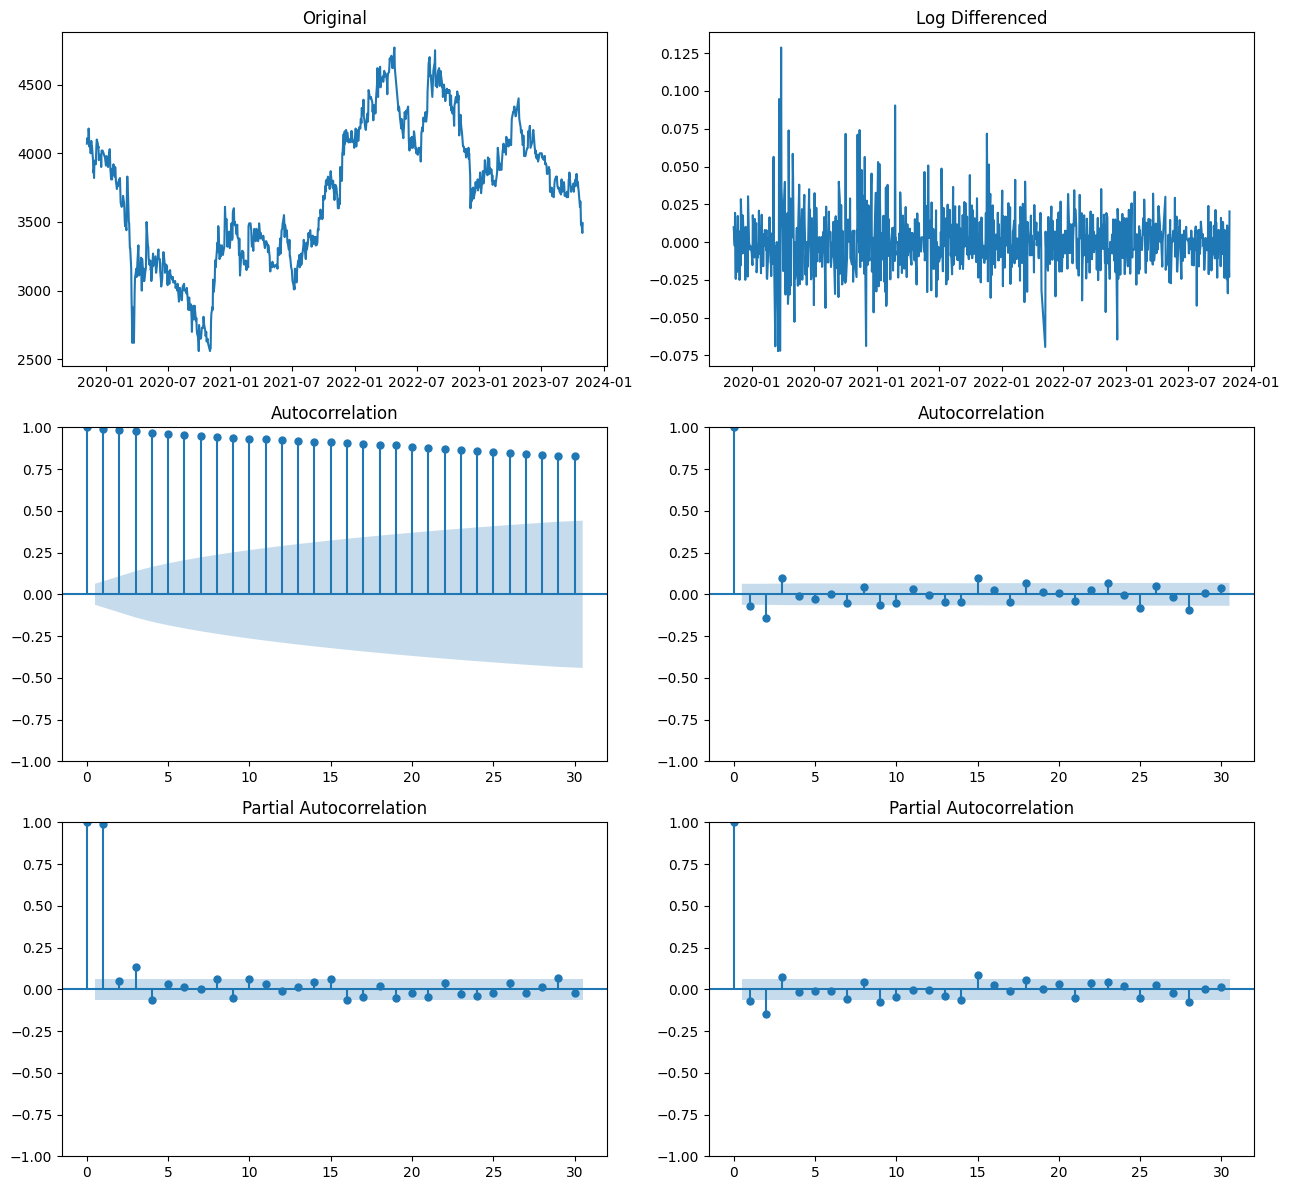

In [ ]:
# ACF & PACF Plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(13, 12))
axes[0, 0].plot(df_train['Close'])
axes[0, 0].set_title('Original')
axes[0, 1].plot(data_log_diff)
axes[0, 1].set_title('Log Differenced')

plot_acf(df_train['Close'], ax=axes[1, 0])
plot_acf(data_log_diff, ax=axes[1, 1])
plot_pacf(df_train['Close'], ax=axes[2, 0])
plot_pacf(data_log_diff, ax=axes[2, 1])
plt.tight_layout()
plt.show()

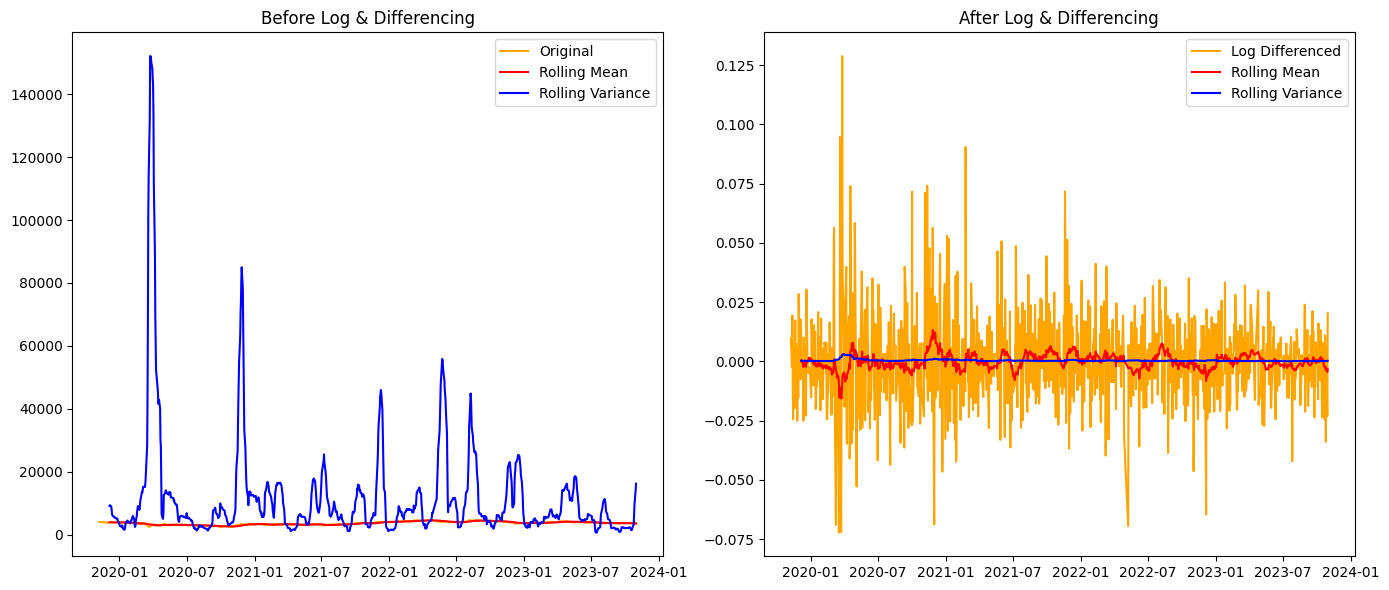

In [ ]:
# Rolling Mean & Variance
rolling_mean = df_train['Close'].rolling(21).mean()
rolling_var = df_train['Close'].rolling(21).var()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(df_train['Close'], label='Original', color='orange')
ax[0].plot(rolling_mean, label='Rolling Mean', color='red')
ax[0].plot(rolling_var, label='Rolling Variance', color='blue')
ax[0].set_title('Before Log & Differencing')
ax[0].legend()

rolling_mean2 = data_log_diff.rolling(21).mean()
rolling_var2 = data_log_diff.rolling(21).var()
ax[1].plot(data_log_diff, label='Log Differenced', color='orange')
ax[1].plot(rolling_mean2, label='Rolling Mean', color='red')
ax[1].plot(rolling_var2, label='Rolling Variance', color='blue')
ax[1].set_title('After Log & Differencing')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Model Auto ARIMA
start_time = time.time()
model_arima = auto_arima(data_log, trace=True, stepwise=True,
                         error_action='ignore', suppress_warnings=True,
                         seasonal=False, stationary=False,
                         start_p=0, start_q=0, max_p=5, max_q=5, d=1)
end_time = time.time()

print(f"\nModel fitted in {end_time - start_time:.2f} seconds")
print(model_arima.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4901.936, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4904.635, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4906.389, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4903.870, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4910.015, Time=5.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4926.973, Time=1.56 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4923.711, Time=0.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4925.593, Time=3.43 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4925.722, Time=2.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4924.143, Time=6.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4927.326, Time=0.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-4925.653, Time=0.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-4923.661, Time=1.27 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-4929.238, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4925.605, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-4927.561, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-4927.140, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4928.877, Time=0.67 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-4925.561, Time=0.52 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 25.942 seconds

Model fitted in 25.95 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  969
Model:               SARIMAX(3, 1, 0)   Log Likelihood                2468.619
Date:                Thu, 26 Jun 2025   AIC                          -4929.238
Time:                        14:57:45   BIC                          -4909.737
Sample:                    

In [ ]:
# Evaluasi Residual
import statsmodels.api as sm
residuals = model_arima.resid()
ljung_box = sm.stats.acorr_ljungbox(residuals, lags=[2], return_df=True)
print("\nHasil Uji Ljung-Box:\n", ljung_box)


Hasil Uji Ljung-Box:
    lb_stat  lb_pvalue
2  0.00144    0.99928


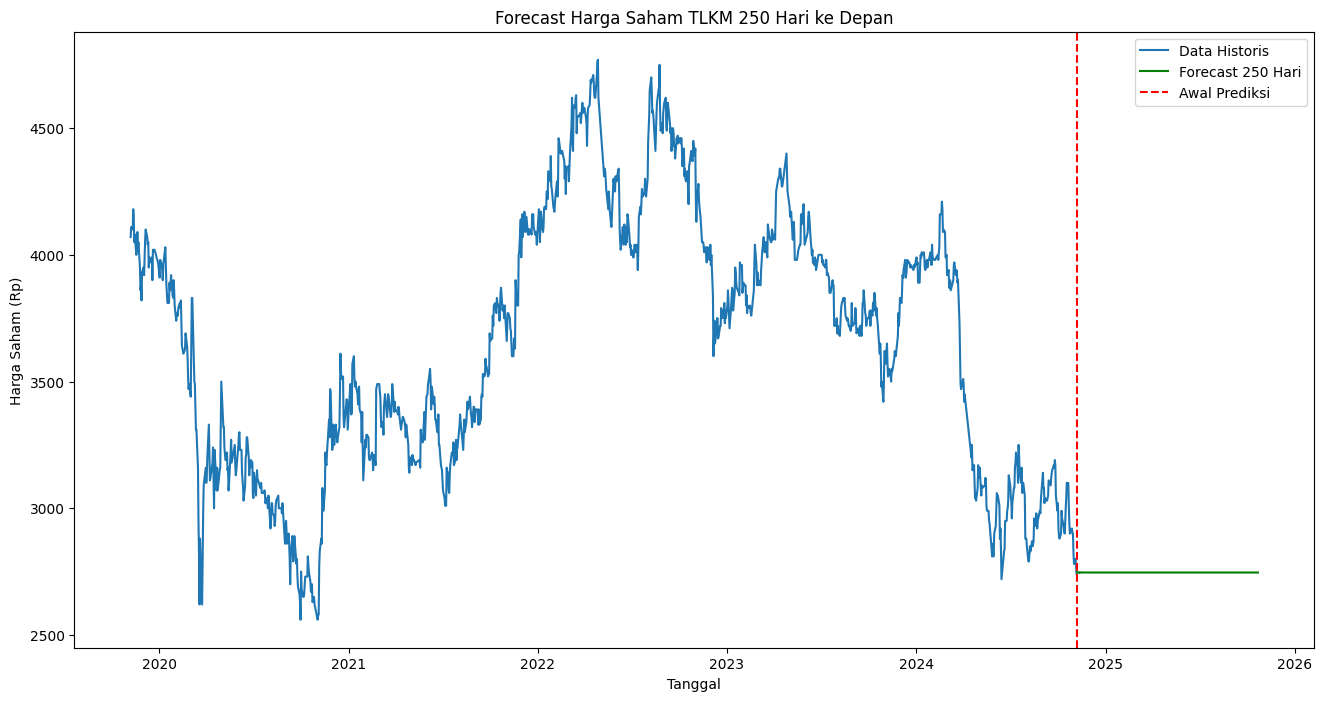

In [ ]:
# Forecast 250 Hari ke Depan
model_final = auto_arima(np.log(df_close['Close']), trace=False, stepwise=True, seasonal=False)
forecast_log = model_final.predict(n_periods=250)
forecast = np.exp(forecast_log)

# Tanggal prediksi
future_dates = pd.date_range(start=df_close.index[-1] + pd.Timedelta(days=1), periods=250, freq='B')

# Plot Forecast
plt.figure(figsize=(16, 8))
plt.plot(df_close, label='Data Historis')
plt.plot(future_dates, forecast, label='Forecast 250 Hari', color='green')
plt.axvline(x=df_close.index[-1], linestyle='--', color='red', label='Awal Prediksi')
plt.title('Forecast Harga Saham TLKM 250 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham (Rp)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prediksi test set
n_test = len(df_test)
forecast_test_log = model_final.predict(n_periods=n_test)
forecast_test = np.exp(forecast_test_log)

# Data aktual
actual_test = df_test['Close'].values

# Hitung metrik error
mae = mean_absolute_error(actual_test, forecast_test)
mse = mean_squared_error(actual_test, forecast_test)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_test - forecast_test) / actual_test)) * 100
r2 = r2_score(actual_test, forecast_test)

# Cetak hasil
print(f"MAE  = {mae:.2f}")
print(f"MSE  = {mse:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"MAPE = {mape:.2f}%")
print(f"R²   = {r2:.4f}")

MAE  = 620.12
MSE  = 585826.97
RMSE = 765.39
MAPE = 17.01%
R²   = -1.9056


# **LSTM**

In [ ]:
# Kolom 'Close' yang akan kita gunakan dalam membangun model
# Slice kolom 'Close'
data_price = data.iloc[:,1:2].values

In [ ]:
# Men-skalakan data antara 1 dan 0 (scaling) pada data_price
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
price_scaled = scaler.fit_transform(data_price)

In [ ]:
# Windowing
step_size = 21
X, y = [], []
for i in range(step_size, len(price_scaled)):
    X.append(price_scaled[i-step_size:i, 0])
    y.append(price_scaled[i, 0])

X = np.array(X)
y = np.array(y)

In [ ]:
# STEP 4: Split Train/Test
split_idx = int(len(X) * 0.8)
train_x, train_y = X[:split_idx], y[:split_idx]
test_x, test_y = X[split_idx:], y[split_idx:]

train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

In [ ]:
# STEP 5: Build LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation="tanh", return_sequences=True, input_shape=(step_size, 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(64, activation="tanh", return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())

lstm_model.add(LSTM(64, activation="tanh", return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(BatchNormalization())

lstm_model.add(Dense(1))
lstm_model.compile(optimizer="adam", loss="mse")

In [ ]:
# STEP 6: Fit Model
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lstm_model.fit(train_x, train_y, epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 1.6146
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.7178
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.5517
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.5148
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.4220
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3553
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3118
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.2630
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.2341
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.2344
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.2083
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1841
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1428
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1406
Epoch 15/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - l

In [ ]:
# STEP 7: Evaluasi pada Test Set
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
pred_test_scaled = lstm_model.predict(test_x)
pred_test = scaler.inverse_transform(pred_test_scaled)
actual_test = scaler.inverse_transform(test_y.reshape(-1,1))

# Hitung metrik evaluasi
mape_val = mean_absolute_percentage_error(actual_test, pred_test)
mse_val = mean_squared_error(actual_test, pred_test)
mae_val = mean_absolute_error(actual_test, pred_test)
r2_val = r2_score(actual_test, pred_test)

print("\n=== Evaluasi Model LSTM (Test Set) ===")
print(f"MAE  = {mae_val:.4f}")
print(f"MSE  = {mse_val:.4f}")
print(f"MAPE = {mape_val*100:.2f}%")
print(f"R²   = {r2_val:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

=== Evaluasi Model LSTM (Test Set) ===
MAE  = 113.2753
MSE  = 19034.6601
MAPE = 3.53%
R²   = 0.8510


In [ ]:
# STEP 8: Forecast 1 Tahun ke Depan (250 Hari)
def forecast_lstm(model, last_seq, steps, step_size=21):
    forecast = []
    current_input = last_seq.copy()
    for _ in range(steps):
        pred = model.predict(current_input.reshape(1, step_size, 1), verbose=0)[0, 0]
        forecast.append(pred)
        current_input = np.append(current_input[1:], [[pred]], axis=0)
    return np.array(forecast)

last_sequence = price_scaled[-step_size:]
forecast_scaled = forecast_lstm(lstm_model, last_sequence, steps=250)
forecast_actual = scaler.inverse_transform(forecast_scaled.reshape(-1,1))

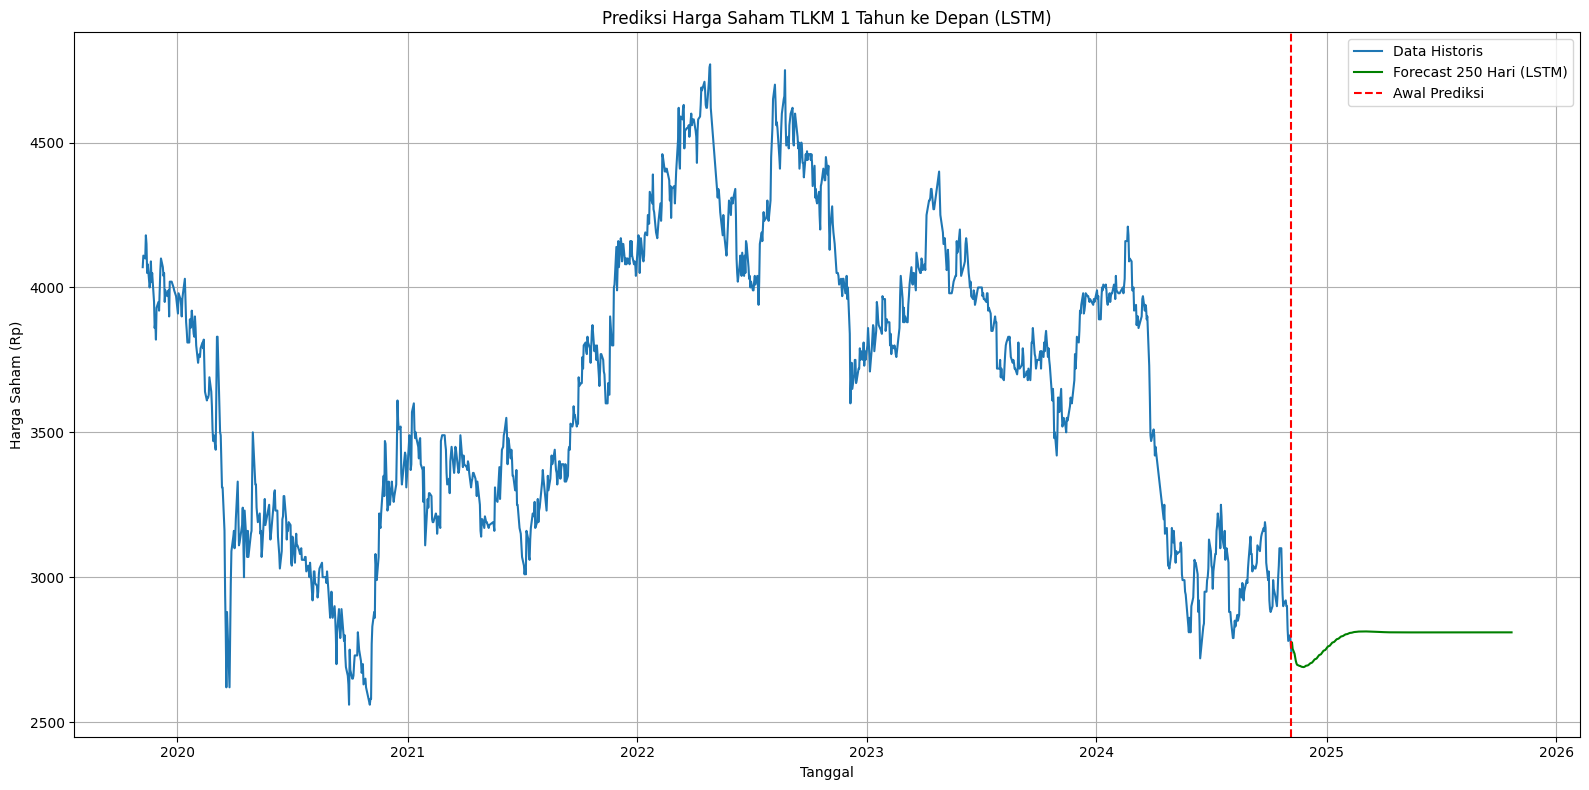

In [ ]:
# STEP 9: Plot Forecast
forecast_dates = pd.date_range(start=data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=250, freq='B')

plt.figure(figsize=(16, 8))
plt.plot(data['Date'], data['Close'], label='Data Historis')
plt.plot(forecast_dates, forecast_actual, label='Forecast 250 Hari (LSTM)', color='green')
plt.axvline(x=data['Date'].iloc[-1], color='red', linestyle='--', label='Awal Prediksi')
plt.title("Prediksi Harga Saham TLKM 1 Tahun ke Depan (LSTM)")
plt.xlabel("Tanggal")
plt.ylabel("Harga Saham (Rp)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **PSO-LSTM**

In [ ]:
data = pd.read_csv('/content/SAHAM - PT Telekomunikasi Indonesia Tbk (TLKM.JK) - Sheet1 (2).csv')
df_close = data[['Date', 'Close']]
df_close['Date'] = pd.to_datetime(df_close['Date'], format='%d/%m/%Y')
df_close.set_index('Date', inplace=True)

In [ ]:
split = int(len(df_close) * 0.8)
df_train = df_close[:split]
df_test = df_close[split:]

In [ ]:
# STEP 3: NORMALISASI & WINDOWING
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train[['Close']])
test_scaled = scaler.transform(df_test[['Close']])

In [ ]:
def make_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 10
X_train, y_train = make_window(train_scaled, window_size)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# STEP 4: PSO FITNESS FUNCTION
def fitness_function(params):
    results = []
    for p in params:
        units = int(p[0])
        lr = p[1]
        model = Sequential()
        model.add(LSTM(units, input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        pred = model.predict(X_train)
        mse = mean_squared_error(y_train, pred)
        results.append(mse)
    return np.array(results)

In [ ]:
# STEP 5: RUN PSO
import pyswarms as ps
import tensorflow as tf

bounds = ([10, 0.0001], [100, 0.01])
optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=2,
    options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=bounds)
best_cost, best_pos = optimizer.optimize(fitness_function, iters=5)

2025-06-26 15:26:48,115 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/5

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


pyswarms.single.global_best:  20%|██        |1/5, best_cost=0.0015

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


pyswarms.single.global_best:  40%|████      |2/5, best_cost=0.00147

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


pyswarms.single.global_best:  60%|██████    |3/5, best_cost=0.00132

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


pyswarms.single.global_best:  80%|████████  |4/5, best_cost=0.00132

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=0.00132
2025-06-26 15:30:04,920 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0013150626645139349, best pos: [8.31316931e+01 8.59115189e-03]


In [ ]:
# STEP 6: FINAL MODEL WITH BEST PARAMS
best_units = int(best_pos[0])
best_lr = best_pos[1]
model = Sequential()
model.add(LSTM(best_units, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr))
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0870
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0034
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0017
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0016
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014
Epoc

In [ ]:
# STEP 7: FORECASTING
def forecast_future(model, last_window, steps=20):
    forecast = []
    input_seq = last_window.copy()
    for _ in range(steps):
        input_reshaped = input_seq.reshape((1, input_seq.shape[0], 1))
        next_val = model.predict(input_reshaped, verbose=0)[0, 0]
        forecast.append(next_val)
        input_seq = np.append(input_seq[1:], [[next_val]], axis=0)
    return np.array(forecast)

last_window = train_scaled[-window_size:]
forecast_scaled = forecast_future(model, last_window, steps=len(df_test))
forecast_actual = scaler.inverse_transform(forecast_scaled.reshape(-1, 1))


=== Evaluasi PSO-LSTM ===
Units: 83, Learning Rate: 0.008591
RMSE : 2604.3565
MAE  : 2069.7444
MAPE : 68.24%


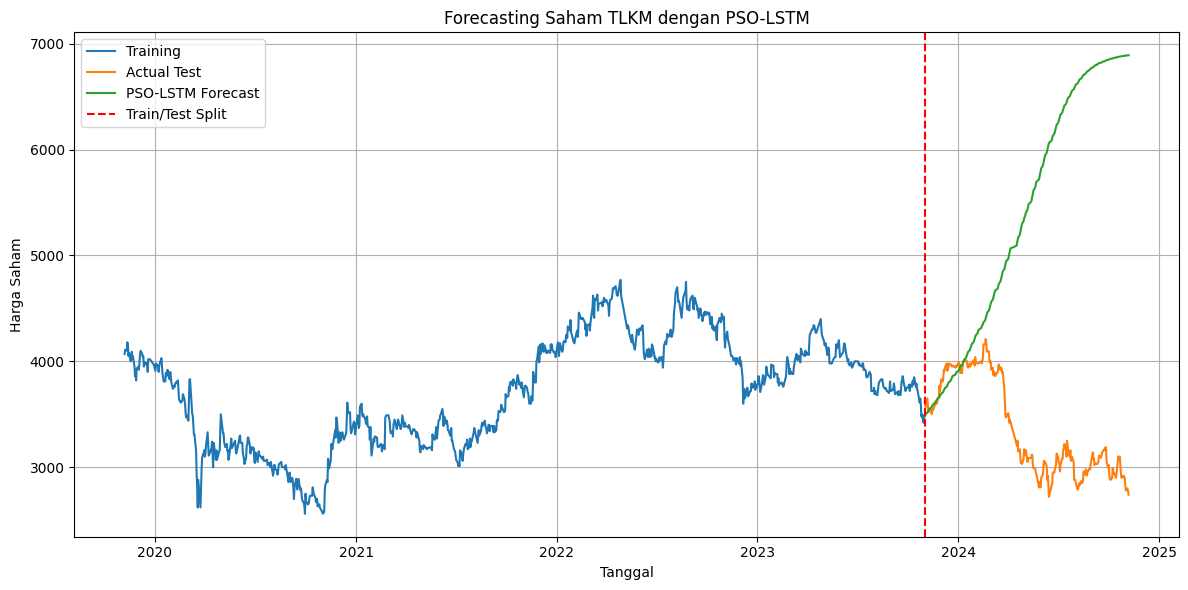

In [ ]:
# STEP 8: EVALUASI & PLOT
actual_test = df_test['Close'].values
rmse = np.sqrt(mean_squared_error(actual_test, forecast_actual))
mae = mean_absolute_error(actual_test, forecast_actual)
mape = mean_absolute_percentage_error(actual_test, forecast_actual) * 100

print("\n=== Evaluasi PSO-LSTM ===")
print(f"Units: {best_units}, Learning Rate: {best_lr:.6f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MAPE : {mape:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(df_train.index, df_train['Close'], label='Training')
plt.plot(df_test.index, actual_test, label='Actual Test')
plt.plot(df_test.index, forecast_actual, label='PSO-LSTM Forecast')
plt.axvline(x=df_test.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.title("Forecasting Saham TLKM dengan PSO-LSTM")
plt.xlabel("Tanggal")
plt.ylabel("Harga Saham")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()